# MRE Replication

This notebook replicates the MRE results for trees from the paper.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [10]:
# SETUP
sns.set_theme(style="darkgrid")

# PATHS
PROBABILITIES_DIR = Path("../../data/probabilities")

In [12]:
# load all probabilities into a dataframe

df_dict = {
    "simulation": [],
    "replica": [],
    "sample_size": [],
    "tree": [],
    "probability": [],
    "method": [],
    "newick": [],
}

for file in PROBABILITIES_DIR.glob("*.csv"):
    name_parts = file.stem.split("-")
    simulation_name = "-".join(name_parts[:-3])
    replica_name = name_parts[-3]
    sample_name = name_parts[-2]
    method_name = name_parts[-1]

    with open(file, "r") as handle:
        for line in handle:
            parts = line.strip().split(",") 
            tree_name = parts[0]
            probability = parts[1]

            df_dict["simulation"].append(simulation_name)
            df_dict["replica"].append(replica_name)
            df_dict["sample_size"].append(int(sample_name))
            df_dict["tree"].append(tree_name)
            df_dict["probability"].append(float(probability))
            df_dict["method"].append(method_name)

            if len(parts) > 2:
                df_dict["newick"].append("-".join(parts[2:]))
            else:
                df_dict["newick"].append("")

df = pd.DataFrame(df_dict)

In [13]:
# calculate the absolute error between the golden probability and the probability of the simulation

golden_df = df[df["method"] == "golden"]
df["golden_probability"] = df.merge(golden_df, on=["simulation", "replica", "tree"], how="left")["probability_y"]
df["relative_error"] = (df.golden_probability - df.probability).abs() / df.golden_probability

In [14]:
# determine the trees within 50% credibility set

unique_binary_trees = golden_df.drop_duplicates(["simulation", "replica", "newick"])
unique_binary_trees = unique_binary_trees.sort_values("probability", inplace=False)
unique_binary_trees["cum_probability"] = (
    unique_binary_trees
    [["simulation", "replica", "probability"]]
    .groupby(["simulation", "replica"])
    ["probability"]
    .cumsum()
)

credibility_50_trees = unique_binary_trees[0.5 < unique_binary_trees.cum_probability]
credibility_50_newick = set(credibility_50_trees.newick)

golden_df["50_credible"] = golden_df.newick.isin(credibility_50_newick)
df["50_credible"] = df.merge(golden_df, on=["simulation", "replica", "tree"], how="left")["50_credible"]

/var/folders/f_/r0jt4c1153v7d286lm9gbgx80000gn/T/ipykernel_34789/4064625578.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  golden_df["50_credible"] = golden_df.newick.isin(credibility_50_newick)


In [15]:
# summarize the trees on a replica level

df["sample_size_str"] = df.sample_size.astype(str)

df_simulations = (
    df
    [df["50_credible"]]
    [["simulation", "replica", "method", "sample_size_str", "sample_size", "relative_error"]]
    .groupby(["simulation", "replica", "method", "sample_size_str", "sample_size"])
    .mean()
    .sort_values(["sample_size"])
)

(0.008, 1.0)

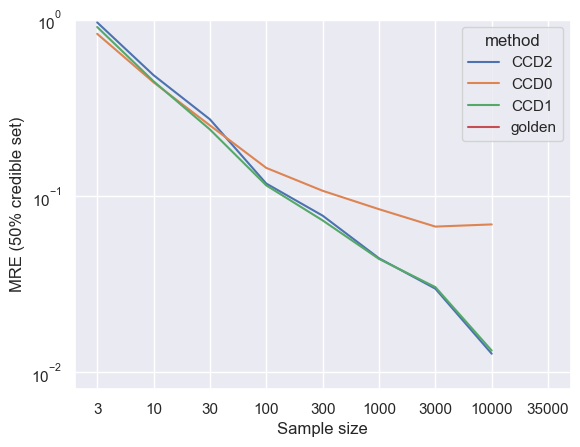

In [16]:
# plot the MRE

sns.lineplot(
    data=df_simulations, 
    x="sample_size_str", 
    y="relative_error", 
    estimator="median", 
    errorbar=None, 
    hue="method",
)

plt.xlabel("Sample Size")

plt.ylabel("MRE (50% credible set)")
plt.yscale("log")
plt.yticks([1, 0.1, 0.01])
plt.ylim([0.008, 1])